# Time Series Analysis
Akshitha Ramachandran <br>

In [1]:
import warnings
import itertools
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from pylab import rcParams
plt.style.use('fivethirtyeight')
%matplotlib inline

/Users/akshitharamachandran/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# Import/Clean Data
- Convert all times to datetime stamps
- Add column for years
- Add column for months
- Add column for hour of day

In [2]:
accident_data = pd.read_csv("updated_accident_data.csv")

In [3]:
accident_data['dispatch_ts'] = pd.to_datetime(accident_data.dispatch_ts)

In [4]:
accident_data.dtypes

dispatch_ts      datetime64[ns]
mode_type                object
location_type            object
street                   object
xstreet1                 object
xstreet2                 object
x_cord                  float64
y_cord                  float64
lat                     float64
long                    float64
dtype: object

In [5]:
accident_data['year'] = accident_data['dispatch_ts'].dt.year
accident_data['month'] = accident_data['dispatch_ts'].dt.month
accident_data['hour'] = accident_data['dispatch_ts'].dt.hour
accident_data['weekday'] = accident_data['dispatch_ts'].dt.dayofweek
accident_data['day'] = accident_data['dispatch_ts'].dt.day

In [6]:
# Export to csv
accident_data.to_csv("accident_data_parsed.csv")

In [7]:
years = accident_data['year'].unique()
months = accident_data['month'].unique()
hours = accident_data['hour'].unique()
modes = accident_data['mode_type'].unique()
loc_types = accident_data['location_type'].unique()
weekdays = accident_data['weekday'].unique()

In [8]:
accident_data.head()

,dispatch_ts,mode_type,location_type,street,xstreet1,xstreet2,x_cord,y_cord,lat,long,year,month,hour,weekday,day
0,2015-01-01 00:24:27,mv,Intersection,NaN,TRAIN ST,WESTGLOW ST,777243.68,2930930.11,42.289750,-71.052515,2015,1,0,3,1
1,2015-01-01 03:50:33,mv,Street,RIVER ST,WALTER ST,WINTHROP ST,758927.71,2918981.60,42.257079,-71.120105,2015,1,3,3,1
2,2015-01-01 10:14:13,ped,Intersection,NaN,LONDON ST,MERIDIAN ST,780725.19,2961410.17,42.373337,-71.039040,2015,1,10,3,1
3,2015-01-01 18:23:57,bike,Intersection,NaN,OLNEY ST,INWOOD ST,772710.48,2936614.62,42.305413,-71.069163,2015,1,18,3,1
4,2015-01-01 18:42:19,ped,Intersection,NaN,WASHINGTON ST,COLUMBUS AVE,764813.61,2940364.63,42.315809,-71.098290,2015,1,18,3,1


# Data Transformation

In [9]:
accident_data = accident_data.set_index(['dispatch_ts'])
accident_data['count'] = 1
accident_data = accident_data['count'].resample('MS').count().to_frame()
accident_data = accident_data.rename(columns={"count": "accidents"})

In [10]:
accident_data.shape

(60, 1)

# Visualize Data Clustered at each Month

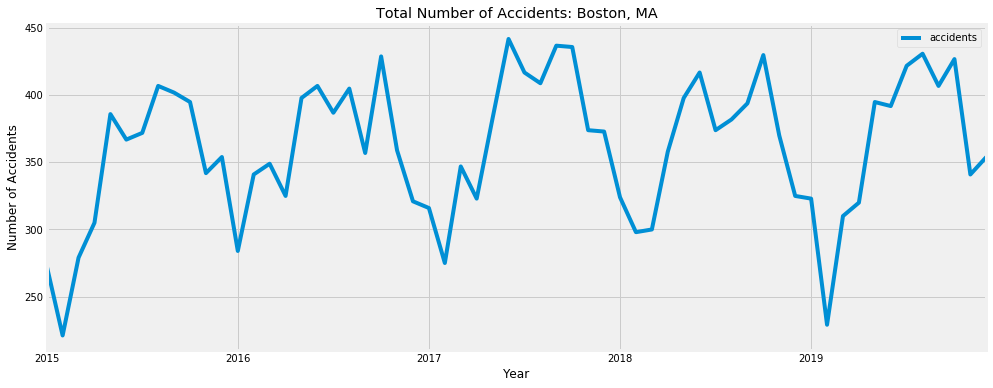

In [11]:
accident_data.plot(figsize=(15, 6))
plt.xlabel('Year')
plt.ylabel('Number of Accidents')
plt.title('Total Number of Accidents: Boston, MA')
plt.show()

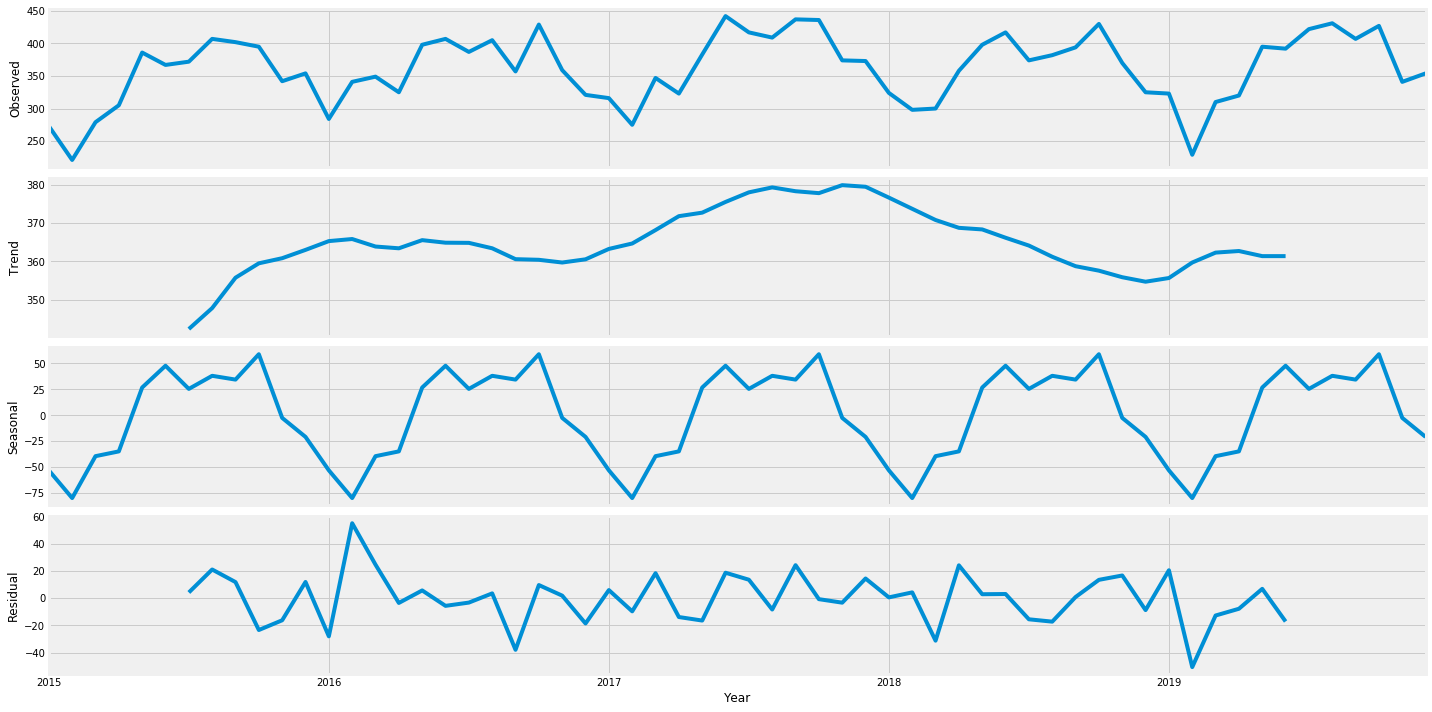

In [12]:
rcParams['figure.figsize'] = 20, 10
decomposition = sm.tsa.seasonal_decompose(accident_data['accidents'], model='additive')
fig = decomposition.plot()
plt.xlabel('Year')
plt.show()

# Testing Stationarity
Based off of the above graph is does seem that we pass the stationary test. The mean of the series is not a function of time (it does not gradually increase/decrease), the variance of the serires is held roughly constant throughout the time series (homoscedasticity). Finally the covariance of subsequent points are not a function of time. Thus the spread remains roughly constant.

In [13]:
def visualize_stationarity(data):
    # Determing rolling statistics
    roling_mean = data.rolling(window=12,center=False).mean()
    rolling_std = data.rolling(window=12,center=False).std()

    # Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    plt.plot(data, label='Original')
    plt.plot(roling_mean, label='Rolling Mean')
    plt.plot(rolling_std, label = 'Rolling Standard Deviation')
    plt.legend(loc='best')
    plt.xlabel('Year')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()

In [14]:
def dickey_fuller_test(data):
    df_test = adfuller(data)
    df_output = dict(zip(['Test Statistic','p-value','Num Lags','Num Observations Used'], (df_test[0:4])))
    for key, value in df_test[4].items():
        df_output['Critical Value (%s)'%key] = value
    display(pd.DataFrame.from_dict(df_output, orient="index"))

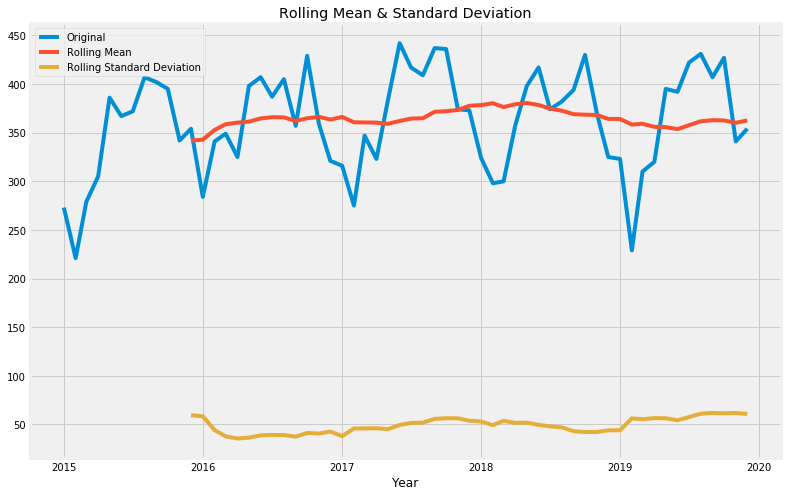

,0
Test Statistic,-2.822266
p-value,0.055163
Num Lags,10.000000
Num Observations Used,49.000000
Critical Value (1%),-3.571472
Critical Value (5%),-2.922629
Critical Value (10%),-2.599336


In [15]:
visualize_stationarity(accident_data)
dickey_fuller_test(accident_data["accidents"])

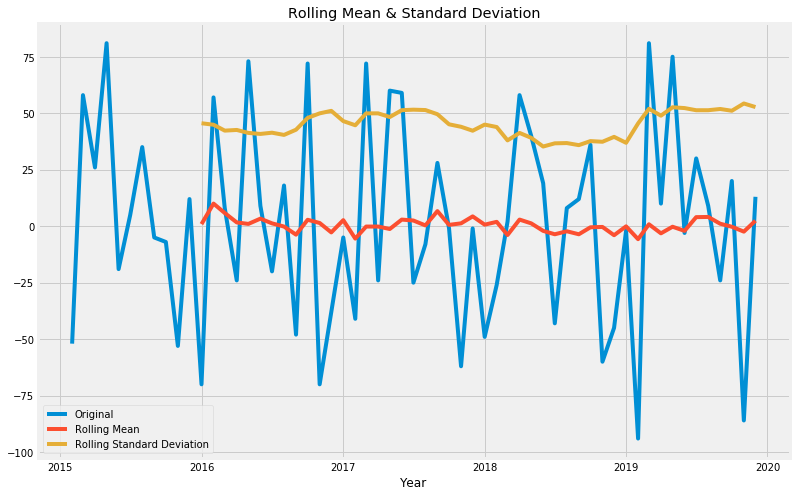

,0
Test Statistic,-5.626902
p-value,0.000001
Num Lags,10.000000
Num Observations Used,48.000000
Critical Value (1%),-3.574589
Critical Value (5%),-2.923954
Critical Value (10%),-2.600039


In [16]:
accident_data['first_diff'] = accident_data.accidents - accident_data.accidents.shift(1)
visualize_stationarity(accident_data.first_diff.dropna(inplace=False))
dickey_fuller_test(accident_data.first_diff.dropna(inplace=False))

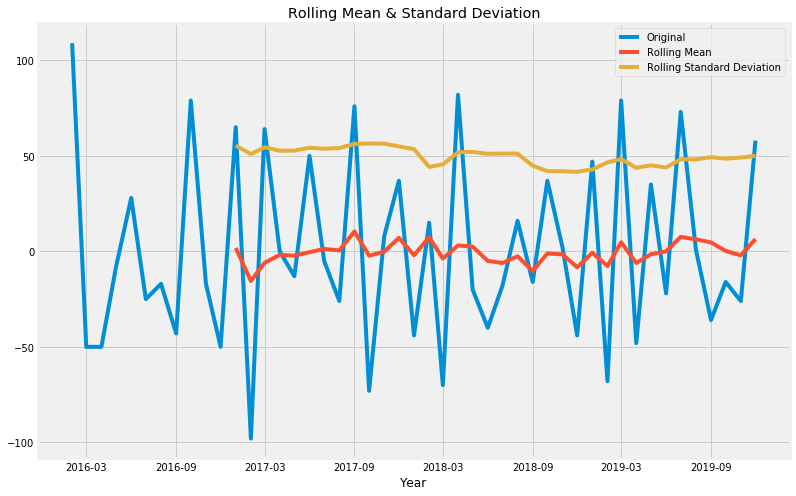

,0
Test Statistic,-8.214656e+00
p-value,6.674250e-13
Num Lags,1.000000e+00
Num Observations Used,4.500000e+01
Critical Value (1%),-3.584829e+00
Critical Value (5%),-2.928299e+00
Critical Value (10%),-2.602344e+00


In [17]:
accident_data['seasonal_first_diff'] = accident_data.first_diff - accident_data.first_diff.shift(12)
visualize_stationarity(accident_data.seasonal_first_diff.dropna(inplace=False))
dickey_fuller_test(accident_data.seasonal_first_diff.dropna(inplace=False))

# ACF and PACF

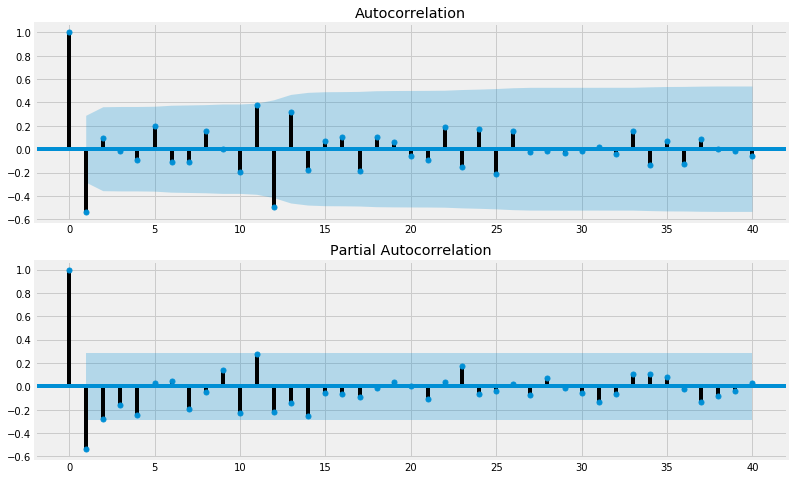

In [18]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(accident_data.seasonal_first_diff.iloc[13:], lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(accident_data.seasonal_first_diff.iloc[13:], lags=40, ax=ax2)

# SARIMA Model Tuning

In [19]:
# source: https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-forecasting-with-arima-in-python-3
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [20]:
warnings.filterwarnings("ignore") # specify to ignore warning messages
aic = 50000

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(accident_data.accidents,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()
            if results.aic < aic:
                print('SARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))
                aic = results.aic
        except:
            continue

SARIMA(0, 0, 0)x(0, 0, 1, 12) - AIC:655.5220639045549
SARIMA(0, 0, 0)x(1, 0, 0, 12) - AIC:488.64706395910514
SARIMA(0, 0, 0)x(1, 0, 1, 12) - AIC:460.1510039324197
SARIMA(0, 0, 0)x(1, 1, 0, 12) - AIC:344.9605578627427
SARIMA(0, 1, 1)x(1, 1, 0, 12) - AIC:334.5983683289618
SARIMA(1, 0, 1)x(1, 1, 0, 12) - AIC:332.9190763295659
SARIMA(1, 1, 1)x(1, 1, 0, 12) - AIC:326.80841400765087


In [21]:
warnings.filterwarnings("ignore") # specify to ignore warning messages
bic = 50000

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(accident_data.accidents,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()
            if results.bic < bic:
                print('SARIMA{}x{} - BIC:{}'.format(param, param_seasonal, results.bic))
                bic = results.bic
        except:
            continue

SARIMA(0, 0, 0)x(0, 0, 1, 12) - BIC:659.7107530289991
SARIMA(0, 0, 0)x(1, 0, 0, 12) - BIC:492.8357530835493
SARIMA(0, 0, 0)x(1, 0, 1, 12) - BIC:466.434037619086
SARIMA(0, 0, 0)x(1, 1, 0, 12) - BIC:349.14924698718687
SARIMA(0, 1, 1)x(1, 1, 0, 12) - BIC:340.88140201562805
SARIMA(1, 1, 0)x(1, 1, 0, 12) - BIC:340.1251825648476
SARIMA(1, 1, 1)x(1, 1, 0, 12) - BIC:335.1857922565393


In [22]:
mod = sm.tsa.statespace.SARIMAX(accident_data.accidents, 
                                order=(1,1,1), seasonal_order=(1,1,0,12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                          accidents   No. Observations:                   60
Model:             SARIMAX(1, 1, 1)x(1, 1, 0, 12)   Log Likelihood                -159.404
Date:                            Fri, 27 Mar 2020   AIC                            326.808
Time:                                    01:20:09   BIC                            335.186
Sample:                                01-01-2015   HQIC                           330.085
                                     - 12-01-2019                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0515      0.241     -0.214      0.831      -0.524       0.421
ma.L1         -0.7810      0.203     -3.854      0.000      -1.178      -0.384
ar.S.L12      -0.5862      0.129     -4.538      0.000      -0.839      -0.333
sigma2       681.5582    181.931      3.746      0.000     324.980    1038.137
===================================================================================
Ljung-Box (Q):                       24.69   Jarque-Bera (JB):                 0.36
Prob(Q):                              0.85   Prob(JB):                         0.84
Heteroskedasticity (H):               1.70   Skew:                            -0.25
Prob(H) (two-sided):                  0.39   Kurtosis:                         2.95
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

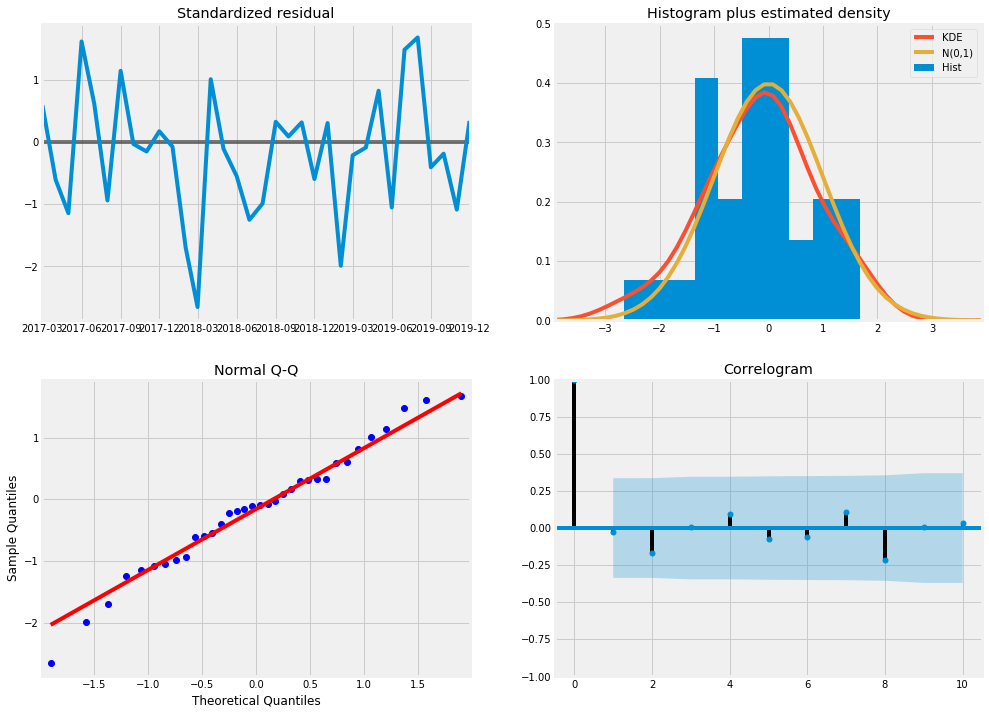

In [23]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

# Predictions

In [24]:
pred = results.get_prediction(start=pd.to_datetime('2018-10-01'), dynamic=False)
pred_ci = pred.conf_int()

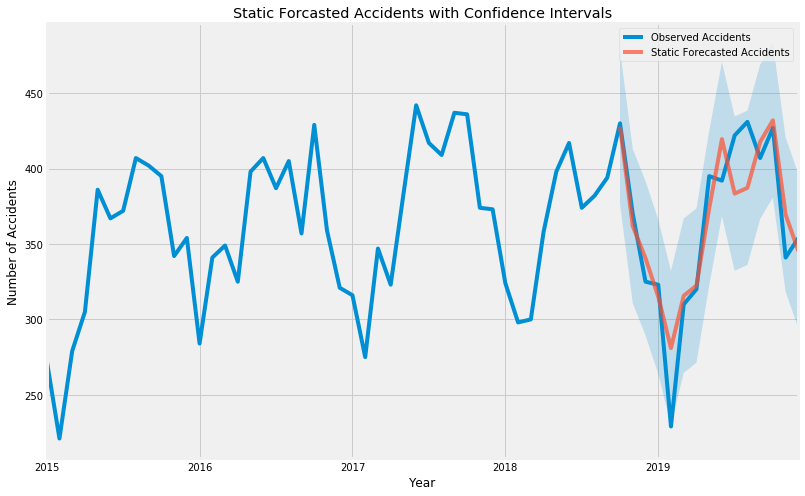

In [25]:
fig = plt.figure(figsize=(12, 8))
ax = accident_data['accidents'].plot(label='Observed Accidents')
pred.predicted_mean.plot(ax=ax, label='Static Forecasted Accidents', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1],
                alpha=.2)

ax.set_xlabel('Year')
ax.set_ylabel('Number of Accidents')
plt.title("Static Forcasted Accidents with Confidence Intervals")
plt.legend(loc='best')
plt.show()

In [26]:
true_val = accident_data['2018-10-01':]['accidents']
predictions = pred.predicted_mean

err = ((predictions - true_val) ** 2).mean()
print("Mean Square Error: ", err)
print("Root Mean Square Error: ", np.sqrt(err))

Mean Square Error:  583.9514303979179
Root Mean Square Error:  24.165087014077105


In [27]:
pred_dynamic = results.get_prediction(start=pd.to_datetime('2018-10-01'), dynamic=True, full_results=True)
pred_ci_dynamic = pred.conf_int()

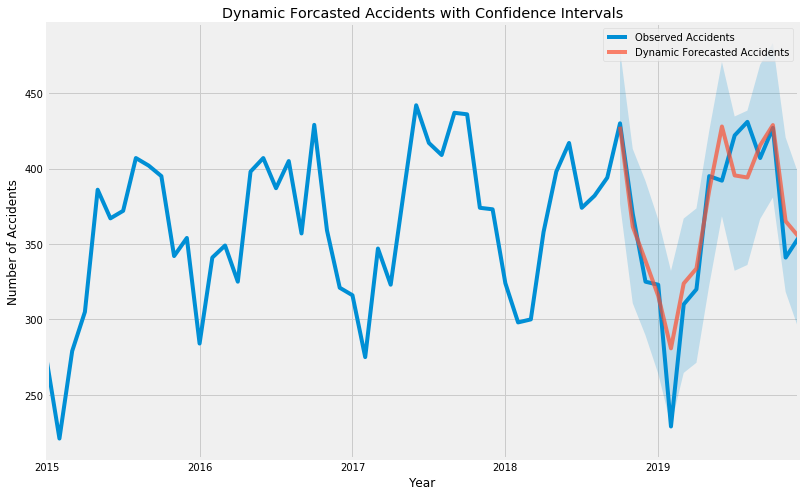

In [28]:
fig = plt.figure(figsize=(12, 8))
ax = accident_data['accidents'].plot(label='Observed Accidents')
pred_dynamic.predicted_mean.plot(ax=ax, label='Dynamic Forecasted Accidents', alpha=.7)

ax.fill_between(pred_ci_dynamic.index,
                pred_ci_dynamic.iloc[:, 0],
                pred_ci_dynamic.iloc[:, 1],
                alpha=.2)

ax.set_xlabel('Year')
ax.set_ylabel('Number of Accidents')
plt.title("Dynamic Forcasted Accidents with Confidence Intervals")
plt.legend(loc='best')
plt.show()

In [29]:
true_val = accident_data['2018-10-01':]['accidents']
predictions = pred_dynamic.predicted_mean

err = ((predictions - true_val) ** 2).mean()
print("Mean Square Error: ", err)
print("Root Mean Square Error: ", np.sqrt(err))

Mean Square Error:  499.2114169865684
Root Mean Square Error:  22.34303956462881


# Forecast

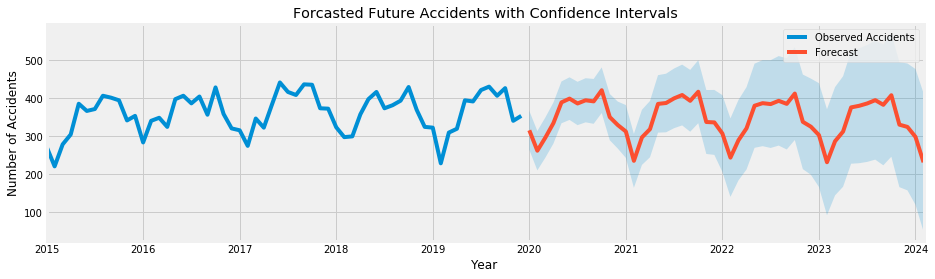

In [30]:
pred_uc = results.get_forecast(steps=50)
pred_ci = pred_uc.conf_int()

ax = accident_data['accidents'].plot(label='Observed Accidents', figsize=(14, 4))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], 
                alpha=.2)
ax.set_xlabel('Year')
ax.set_ylabel('Number of Accidents')
plt.title("Forcasted Future Accidents with Confidence Intervals")
plt.legend(loc="best")
plt.show()

References:

(1) https://www.seanabu.com/2016/03/22/time-series-seasonal-ARIMA-model-in-python/ <br>
(2) https://towardsdatascience.com/how-to-forecast-sales-with-python-using-sarima-model-ba600992fa7d <br>
(3) https://medium.com/analytics-vidhya/sarima-forecasting-seasonal-data-with-python-and-r-2e7472dfad83 <br>
(4) https://machinelearningmastery.com/grid-search-arima-hyperparameters-with-python/ <br>
(5) https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-forecasting-with-arima-in-python-3 <br>
(6) http://people.duke.edu/~rnau/arimrule.htm